In [5]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data exploration

First, I will load the data and check for any errors, missing values or inconsistensies to take care of before next steps in the analysis.

In [6]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Portfolio dataset contains 10 entries, no null values and the only step I will take at this stage is one-hot encode the channel column for easier analysis.

In [8]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

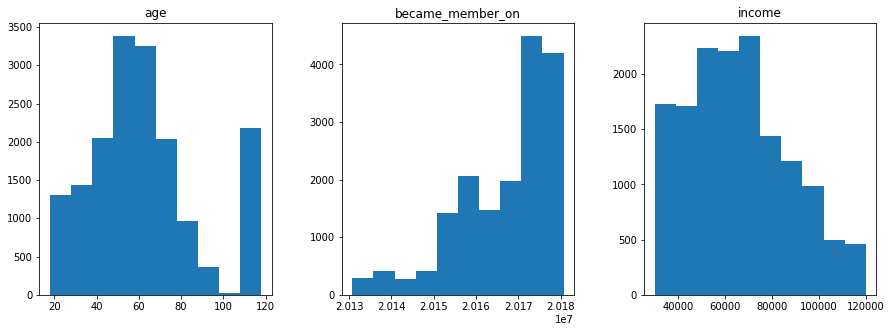

In [11]:
profile.hist(layout = (1, 3), grid = False, figsize=(15, 5));

In [12]:
profile[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Profile contains 17000 values and 2175 of them have null values for gender, income and an age of 118. I know that this data is from an app, where customers might be asked to provide information about themselves. They might be free to not provide some data (e.g. gender or income) and the age value of 118 might be a software bug for all I know. Because I do not enough attributes to infer median values for missing attributes, I will replace age=118 with nulls and then eliminate all null values from the dataset. 

In [13]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

Transcript contains 306534 entries and no null values. Prepration here will be limited to parsing the dictionary column 'value'.

## Data cleaning

In [16]:
portfolio_clean = portfolio.copy()

# rename cols
portfolio_clean.rename(columns = {'id':'offer_id', 'reward':'portfolio_reward'}, inplace = True)

# one_hot encoding for channels
portfolio_channels_one_hot = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack()).sum(level=0)
portfolio_clean = portfolio_clean.drop('channels', axis = 1)
portfolio_clean = portfolio_clean.join(portfolio_channels_one_hot)

In [250]:
profile_clean = profile.copy()

# rename cols
profile_clean.rename(columns = {'id':'profile_id'}, inplace = True)

# replace age 118 with nan
profile_clean['age'] = np.where(profile_clean['age'] == 118.0, np.NaN, profile_clean['age'])

# drop rows containig null values
profile_clean.dropna(subset = ['gender', 'age', 'income'], inplace = True)

# change membership date to datetime and add membership year column
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format = '%Y%m%d')
profile_clean['member_on_year'] = profile_clean['became_member_on'].dt.year
# profile_clean.drop('became_member_on', axis = 1, inplace = True)

In [279]:
# change continuous variables to categorical
profile_clean['age_bin'] = pd.cut(profile_clean['age'], bins = [17, 20, 25, 35, 60, 102], labels=['teen', 'young', 'young-adult', 'adult', 'elderly'])
profile_clean.drop('age', axis = 1, inplace = True)

profile_clean['income_bin'] = pd.cut(profile_clean['income'], bins = [29999, 49000, 64000, 80000, 120001], labels = ['low', 'med-low', 'med-high', 'high'])
profile_clean.drop('income', axis = 1, inplace = True)

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [129]:
transcript_clean = transcript.copy()

# parse dict column
transcript_clean = pd.concat([transcript.drop(['value'], axis = 1), pd.json_normalize(transcript['value'])], axis = 1)

# upon parsing, I find that two columns are created - 'offer id' and 'offer_id'. 
# the former contains offer ids for received and viewed events, while the latter for completed events
# I will coalcesce these values using combine_first

transcript_clean['offer'] = transcript_clean['offer id'].combine_first(transcript_clean['offer_id'])
transcript_clean.drop(['offer id', 'offer_id'], axis = 1, inplace = True)
transcript_clean['offer'] = transcript_clean['offer'].replace('nan', np.NaN)

# rename cols
transcript_clean.rename(columns = {'person': 'profile_id', 'offer': 'offer_id'}, inplace = True)
transcript_clean['offer_id'] = transcript_clean['offer_id']

In [130]:
transcript_clean.head()

,profile_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


To ensure I created no duplicates or introduced other errors during preparation, I will count my n's.

In [131]:
print('Shape of profile before data preparation: {}'.format(profile.shape))
print('Shape of profile after data preparation: {}'.format(profile_clean.shape))
print('Null values after prepration:\n{}'.format(profile_clean.isna().sum()))
print('\nShape of portfolio before data preparation: {}'.format(portfolio.shape))
print('Shape of portfolio before data preparation: {}'.format(portfolio_clean.shape))
print('Null values after prepration:\n{}'.format(portfolio_clean.isna().sum()))
print('\nShape of transcript before data preparation: {}'.format(transcript.shape))
print('Shape of transcript before data preparation: {}'.format(transcript_clean.shape))
print('Null values after prepration:\n{}'.format(transcript_clean.isna().sum()))

Shape of profile before data preparation: (17000, 5)
Shape of profile after data preparation: (14825, 6)
Null values after prepration:
gender              0
age                 0
profile_id          0
became_member_on    0
income              0
member_on_year      0
dtype: int64

Shape of portfolio before data preparation: (10, 6)
Shape of portfolio before data preparation: (10, 9)
Null values after prepration:
portfolio_reward    0
difficulty          0
duration            0
offer_type          0
offer_id            0
email               0
mobile              0
social              0
web                 0
dtype: int64

Shape of transcript before data preparation: (306534, 4)
Shape of transcript before data preparation: (306534, 6)
Null values after prepration:
profile_id         0
event              0
time               0
amount        167581
reward        272955
offer_id      138953
dtype: int64


## Exploratory data analysis

I have two problems to solve:
* BOGO and discount: in case of these offers, I want to check who received, viewed and completed offers - there are entries in the transcript dataset for these events
* Informational: in case of these offers, there are no completion events, but if customer viewed the offer and made a transaction during offer duration period, I can consider that "offer completion"

### BOGO and discount

In [97]:
transcript_offers = transcript_clean[transcript_clean['event'] != 'transaction']
transcript_offers = transcript_offers.merge(portfolio_clean[['offer_id', 'offer_type', 'duration']], on = ['offer_id'])
transcript_offers = transcript_offers[transcript_offers['offer_type'] != 'informational']

In [98]:
received_df = transcript_offers[transcript_offers['event'] == 'offer received'][['profile_id', 'offer_id', 'time', 'duration']]
viewed_df = transcript_offers[transcript_offers['event'] == 'offer viewed'][['profile_id', 'offer_id', 'time']]
completed_df = transcript_offers[transcript_offers['event'] == 'offer completed'][['profile_id', 'offer_id', 'time']]

Next, I want to get all unique instances of profile_id and offer_id. This will give me all customer-offer combinations of received, viewed and completed offers. I will then be able to get attributes for when each action was completed, calculate a response attribute, and finally add dimensions for analysis.

In [99]:
customer_offer_combs = transcript_offers.groupby(['profile_id', 'offer_id']).size().reset_index().drop(columns=0)

In [106]:
offers_master = customer_offer_combs.merge(received_df, how = 'left', on = ['profile_id', 'offer_id'], suffixes = [None, '_received'])
offers_master = offers_master.merge(viewed_df, how = 'left',  on = ['profile_id', 'offer_id'], suffixes = [None, '_viewed'])
offers_master = offers_master.merge(completed_df, how = 'left',  on = ['profile_id', 'offer_id'], suffixes = [None, '_completed'])

In [107]:
offers_master.isnull().sum()

profile_id            0
offer_id              0
time                  0
duration              0
time_viewed       12936
time_completed    29577
dtype: int64

I find that there are no such cases where a customer completed an offer without receiving it, but there can be cases where a customer completes an offer without viewing it, as expected. 

First, I need to determine which views and completions are valid - i.e. they are within the duration period of when offer was sent.

Finally, I can define my response variable as follows:

* receive, view, complete - perfect scenario, send offer to these customers (1)
* receive, not view, complete - customer completes offer without knowing about it, do not send offer (0)
* receive, view, not complete - user not responsive to this type of offer, should send different kind of offer (0)

In [123]:
offers_master['valid_receive'] = 1
offers_master['valid_view'] = np.where(offers_master['time_viewed'] - offers_master['time'] < offers_master['duration']*24, 1, 0)
offers_master['valid_complete'] = np.where(offers_master['time_completed'] - offers_master['time'] < offers_master['duration']*24, 1, 0)
offers_master['response'] = np.where(offers_master['valid_view'] + offers_master['valid_complete'] == 2, 1, 0)
offers_master.drop(['duration', 'time', 'time_viewed', 'time_completed'], axis = 1, inplace = True)

In [179]:
offers_master

,profile_id,offer_id,valid_view,valid_complete,valid_receive,response
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,1,0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1,0
...,...,...,...,...,...,...
96969,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1
96970,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1
96971,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1
96972,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1


### Transactions and informational

In [155]:
portfolio_informational = portfolio_clean[portfolio_clean['offer_type'] == 'informational']
transcript_informational = transcript_clean.merge(portfolio_informational[['offer_id', 'offer_type', 'duration']], how = 'inner', on = ['offer_id'])
transcript_informational.drop(['amount', 'reward'], axis = 1, inplace = True)

In [170]:
transactions_df = transcript_clean[transcript_clean['event'] == 'transaction'][['profile_id','time', 'amount']]
info_viewed_df = transcript_informational[transcript_informational['event'] == 'offer viewed'][['profile_id', 'offer_id','time']]

In [171]:
transactions_df.head(2)

,profile_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56


In [172]:
transcript_informational.head(2)

,profile_id,event,time,offer_id,offer_type,duration
0,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,informational,4
1,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,informational,4


In [173]:
informational_completions = transcript_informational.merge(transactions_df, how = 'left', on = ['profile_id'], suffixes = [None, '_transaction'])
informational_completions = informational_completions.merge(info_viewed_df, how = 'left', on = ['profile_id', 'offer_id'], suffixes = [None, '_viewed'])

In [177]:
informational_completions['valid_receive'] = 1
informational_completions['valid_view'] = np.where(informational_completions['time_viewed'] - informational_completions['time'] < informational_completions['duration']*24, 1, 0)
informational_completions['valid_complete'] = np.where(informational_completions['time_transaction'] - informational_completions['time'] < informational_completions['duration']*24, 1, 0)
informational_completions['response'] = np.where(informational_completions['valid_view'] + informational_completions['valid_complete'] == 2, 1, 0)
informational_completions.drop(['duration', 'time', 'time_viewed', 'time_transaction'], axis = 1, inplace = True)

In [185]:
informational_master = informational_completions.groupby(['profile_id', 'offer_id'])['valid_receive', 'valid_view', 'valid_complete', 'response'].sum().reset_index()
informational_master['valid_receive'] = np.where(informational_master['valid_receive'] > 0, 1, 0)
informational_master['valid_view'] = np.where(informational_master['valid_view'] > 0, 1, 0)
informational_master['valid_complete'] = np.where(informational_master['valid_complete'] > 0, 1, 0)
informational_master['response'] = np.where(informational_master['response'] > 0, 1, 0)

/Users/arunasumbrasas/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


## Exploratory data analysis

In [252]:
master_df = pd.concat([offers_master, informational_master])

In [253]:
master_df = master_df.merge(profile_clean, on = ['profile_id'])
master_df = master_df.merge(portfolio_clean, on = ['offer_id'])

In [254]:
master_df.head()

,profile_id,offer_id,valid_view,valid_complete,valid_receive,response,gender,age,became_member_on,income,...,age_bin,income_bin,portfolio_reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,1,0,M,33.0,2017-04-21,72000.0,...,young-adult,med-high,2,10,7,discount,1,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,F,19.0,2016-08-09,65000.0,...,teen,med-high,2,10,7,discount,1,1,0,1
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,F,19.0,2016-08-09,65000.0,...,teen,med-high,2,10,7,discount,1,1,0,1
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,M,56.0,2017-12-09,47000.0,...,adult,low,2,10,7,discount,1,1,0,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,1,1,1,F,58.0,2017-12-07,119000.0,...,adult,high,2,10,7,discount,1,1,0,1


For exploratory data analysis, I merged informational and bogo+discount offer datasets. I will check if some demographic groups appear to be more responsive to others by looking at their response rates.

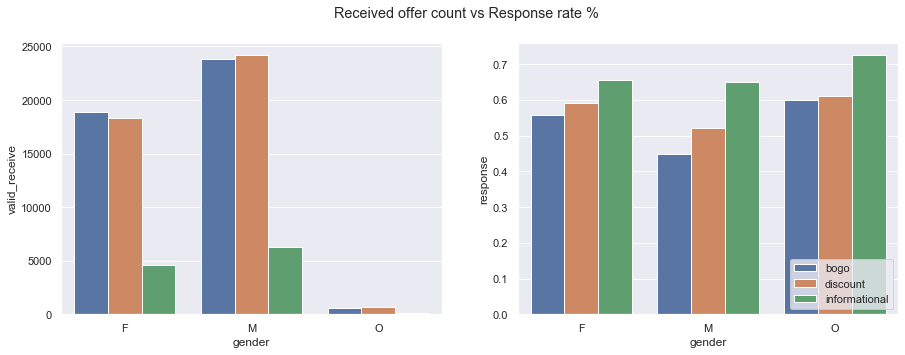

In [334]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle('Received offer count vs Response rate %')

sns.barplot(x = 'gender', 
            y = 'valid_receive', 
            hue = 'offer_type',
            data = master_df.groupby(['gender', 'offer_type'])['valid_receive'].sum().reset_index(),
            ax = axes[0])

sns.barplot(x = 'gender', 
            y = 'response', 
            hue = 'offer_type',
            data = master_df.groupby(['gender', 'offer_type'])['response'].mean().reset_index(),
            ax = axes[1])


axes[0].get_legend().remove()
axes[1].legend(loc='lower right')

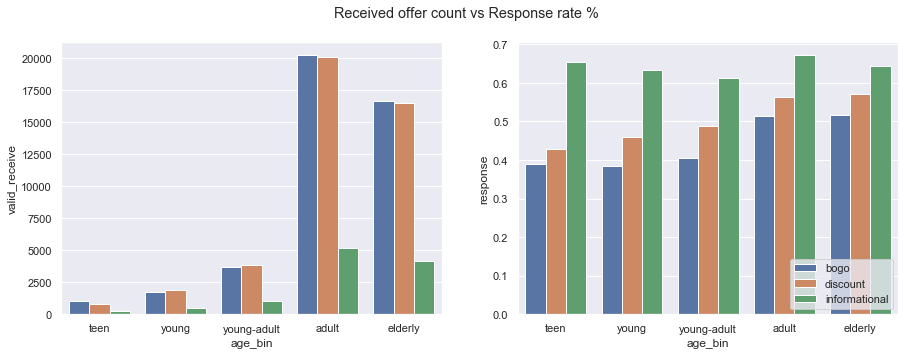

In [333]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle('Received offer count vs Response rate %')

sns.barplot(x = 'age_bin', 
            y = 'valid_receive', 
            hue = 'offer_type',
            data = master_df.groupby(['age_bin', 'offer_type'])['valid_receive'].sum().reset_index(),
            ax = axes[0])

sns.barplot(x = 'age_bin', 
            y = 'response', 
            hue = 'offer_type',
            data = master_df.groupby(['age_bin', 'offer_type'])['response'].mean().reset_index(),
            ax = axes[1])


axes[0].get_legend().remove()
axes[1].legend(loc='lower right')

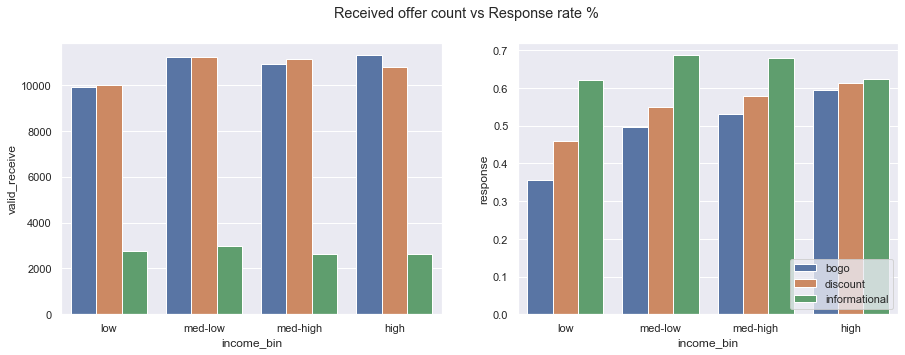

In [335]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle('Received offer count vs Response rate %')

sns.barplot(x = 'income_bin', 
            y = 'valid_receive', 
            hue = 'offer_type',
            data = master_df.groupby(['income_bin', 'offer_type'])['valid_receive'].sum().reset_index(),
            ax = axes[0])

sns.barplot(x = 'income_bin', 
            y = 'response', 
            hue = 'offer_type',
            data = master_df.groupby(['income_bin', 'offer_type'])['response'].mean().reset_index(),
            ax = axes[1])


axes[0].get_legend().remove()
axes[1].legend(loc='lower right')

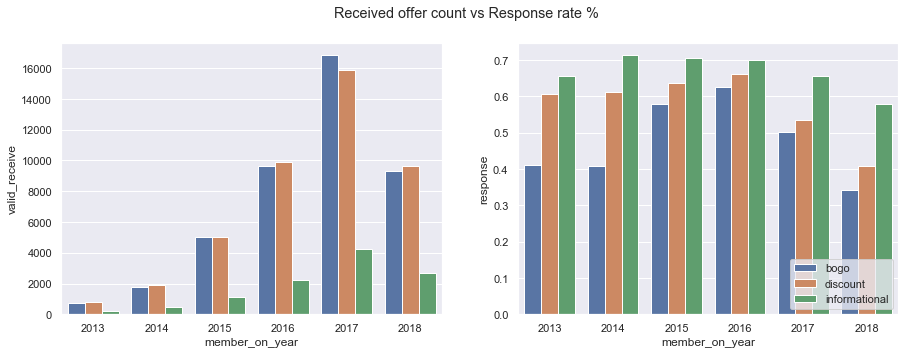

In [336]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle('Received offer count vs Response rate %')

sns.barplot(x = 'member_on_year', 
            y = 'valid_receive', 
            hue = 'offer_type',
            data = master_df.groupby(['member_on_year', 'offer_type'])['valid_receive'].sum().reset_index(),
            ax = axes[0])

sns.barplot(x = 'member_on_year', 
            y = 'response', 
            hue = 'offer_type',
            data = master_df.groupby(['member_on_year', 'offer_type'])['response'].mean().reset_index(),
            ax = axes[1])


axes[0].get_legend().remove()
axes[1].legend(loc='lower right')